In [1]:
import os #provides functions for interacting with the operating system
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, explained_variance_score, mean_absolute_error, mean_squared_error
from math import sqrt
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, explained_variance_score, confusion_matrix, accuracy_score, classification_report, log_loss


# To change scientific numbers to float
np.set_printoptions(formatter={'float_kind':'{:f}'.format})


# view all the dataframe
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

# remove warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None

In [2]:
raw_data = pd.read_csv("C:/Users/Chandru/Downloads/train.csv")
evaluation_data = pd.read_csv("C:/Users/Chandru/Downloads/test.csv")
submission_example = pd.read_csv("C:/Users/Chandru/Downloads/sample_submission.csv")

In [3]:
for col in raw_data.columns:
    nv=len(raw_data[col].unique())
    if nv < 10:
        print(f"Category in {col}:\n {raw_data[col].unique()}\n Number of values:{nv}\n")
        print("\\"*50)
    else:
        print(f"Category in {col}:\n Number of values:{nv}\n")
        print("\\"*50)

Category in PassengerId:
 Number of values:8693

\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\
Category in HomePlanet:
 ['Europa' 'Earth' 'Mars' nan]
 Number of values:4

\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\
Category in CryoSleep:
 [False True nan]
 Number of values:3

\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\
Category in Cabin:
 Number of values:6561

\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\
Category in Destination:
 ['TRAPPIST-1e' 'PSO J318.5-22' '55 Cancri e' nan]
 Number of values:4

\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\
Category in Age:
 Number of values:81

\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\
Category in VIP:
 [False True nan]
 Number of values:3

\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\
Category in RoomService:
 Number of values:1274

\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\
Category in FoodCourt:
 Number of values:1508

\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\
Category in ShoppingMal

In [4]:
raw_data.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [5]:
raw_data.dtypes
# cannot visualise when its objects and float

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object

In [6]:
# changing objects to string and float to integer
strings = ['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination','VIP','Name', 'Transported']
numeric = [ 'Age','RoomService','FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

for i in strings:
    raw_data[i]=raw_data[i].astype("str")

for i in numeric:
    raw_data[i]=raw_data[i].astype("float")

In [7]:
raw_data.dtypes

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported      object
dtype: object

In [8]:
# let us look at the Cabin column
raw_data["Cabin"]
# we can see that it is given in the form deck/number/side

0          B/0/P
1          F/0/S
2          A/0/S
3          A/0/S
4          F/1/S
          ...   
8688      A/98/P
8689    G/1499/S
8690    G/1500/S
8691     E/608/S
8692     E/608/S
Name: Cabin, Length: 8693, dtype: object

In [9]:
df=raw_data.copy()
df[["Deck","Number","Side"]]=df["Cabin"].str.split("/",expand=True)
del df["Cabin"]

In [10]:
df

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Deck,Number,Side
0,0001_01,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,B,0,P
1,0002_01,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,F,0,S
2,0003_01,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,A,0,S
3,0003_02,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,A,0,S
4,0004_01,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,F,1,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False,A,98,P
8689,9278_01,Earth,True,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False,G,1499,S
8690,9279_01,Earth,False,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True,G,1500,S
8691,9280_01,Europa,False,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False,E,608,S


C:\Users\Chandru\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


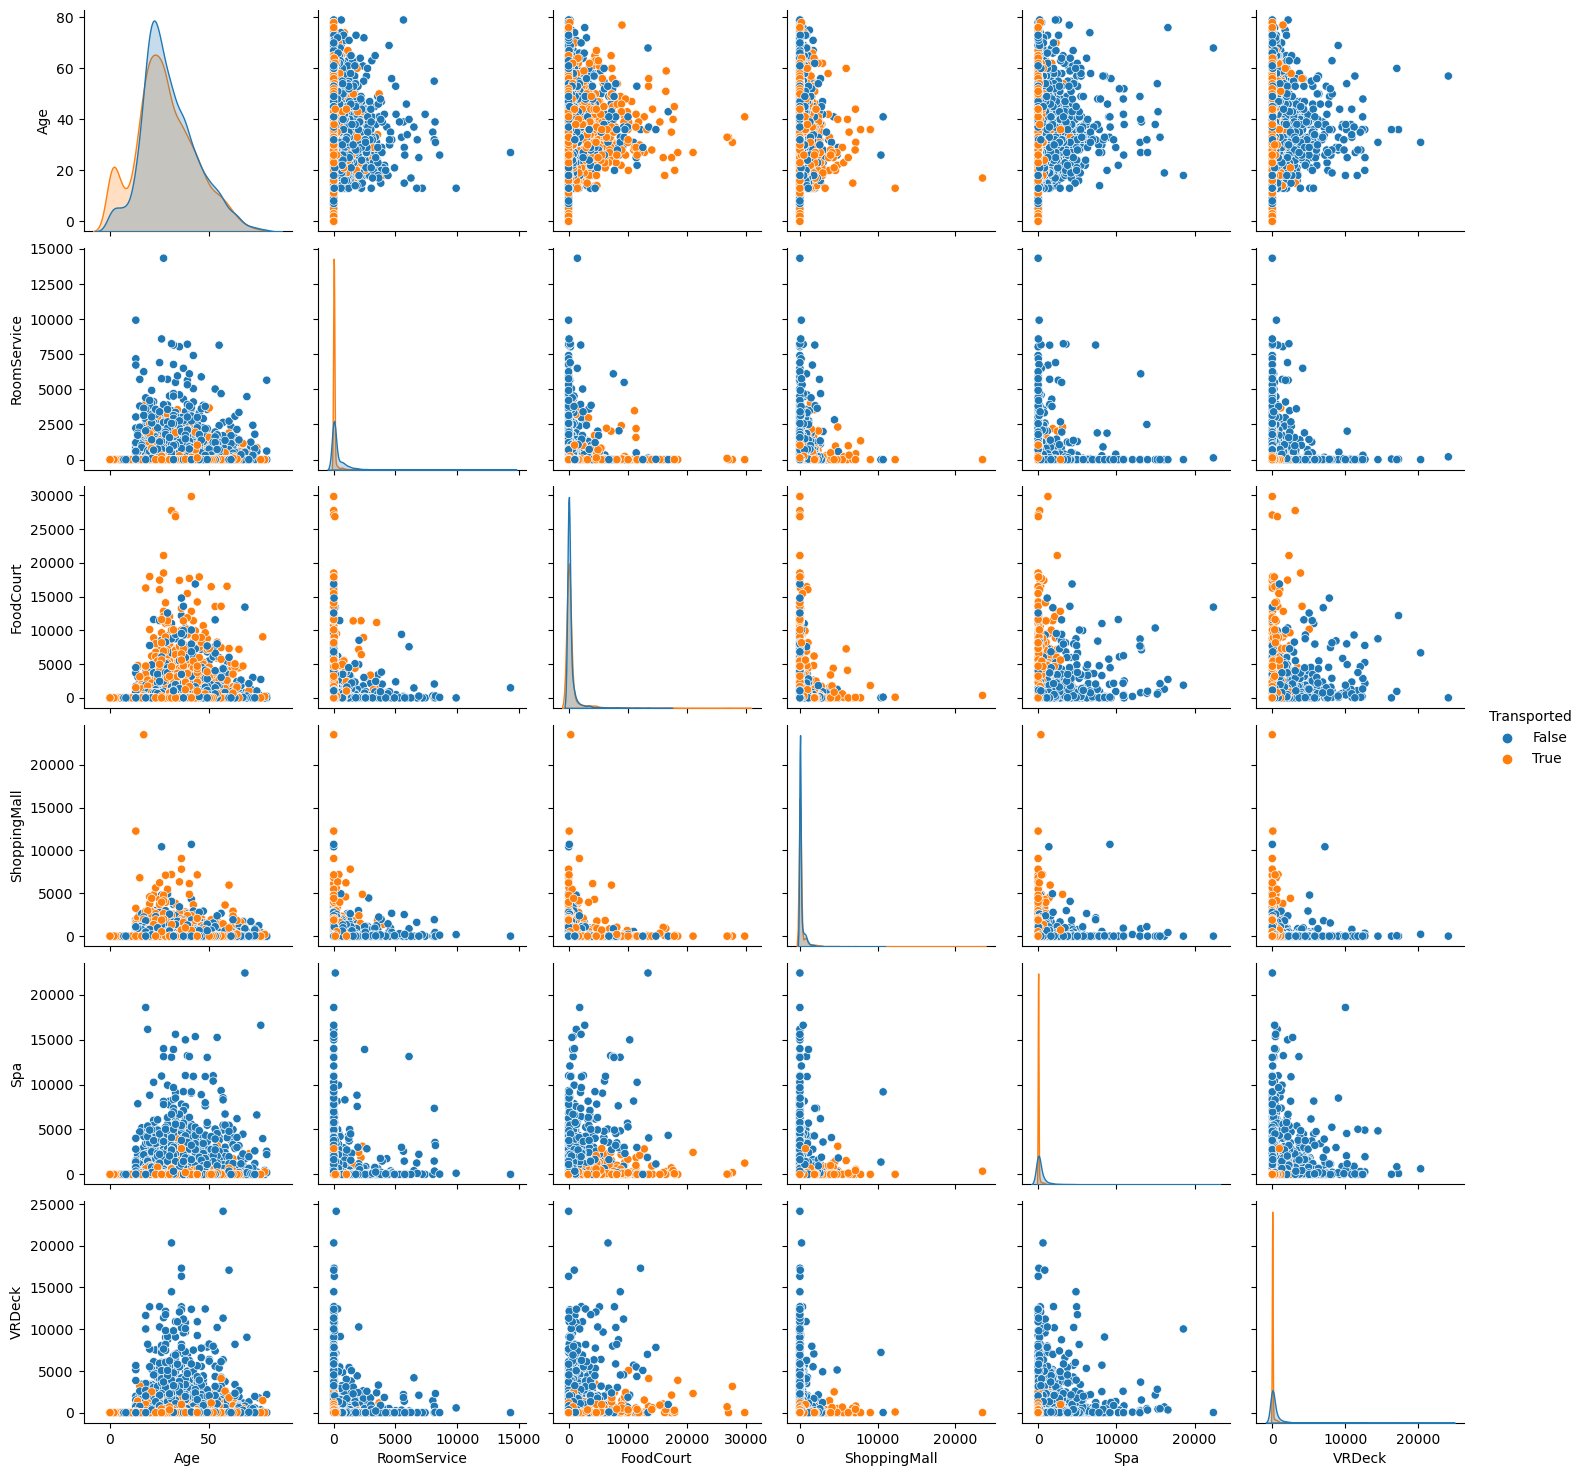

In [11]:
# always try to run pairplot on numeric columns
a=sns.pairplot(df[['Age','RoomService','FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck','Transported']],hue='Transported');

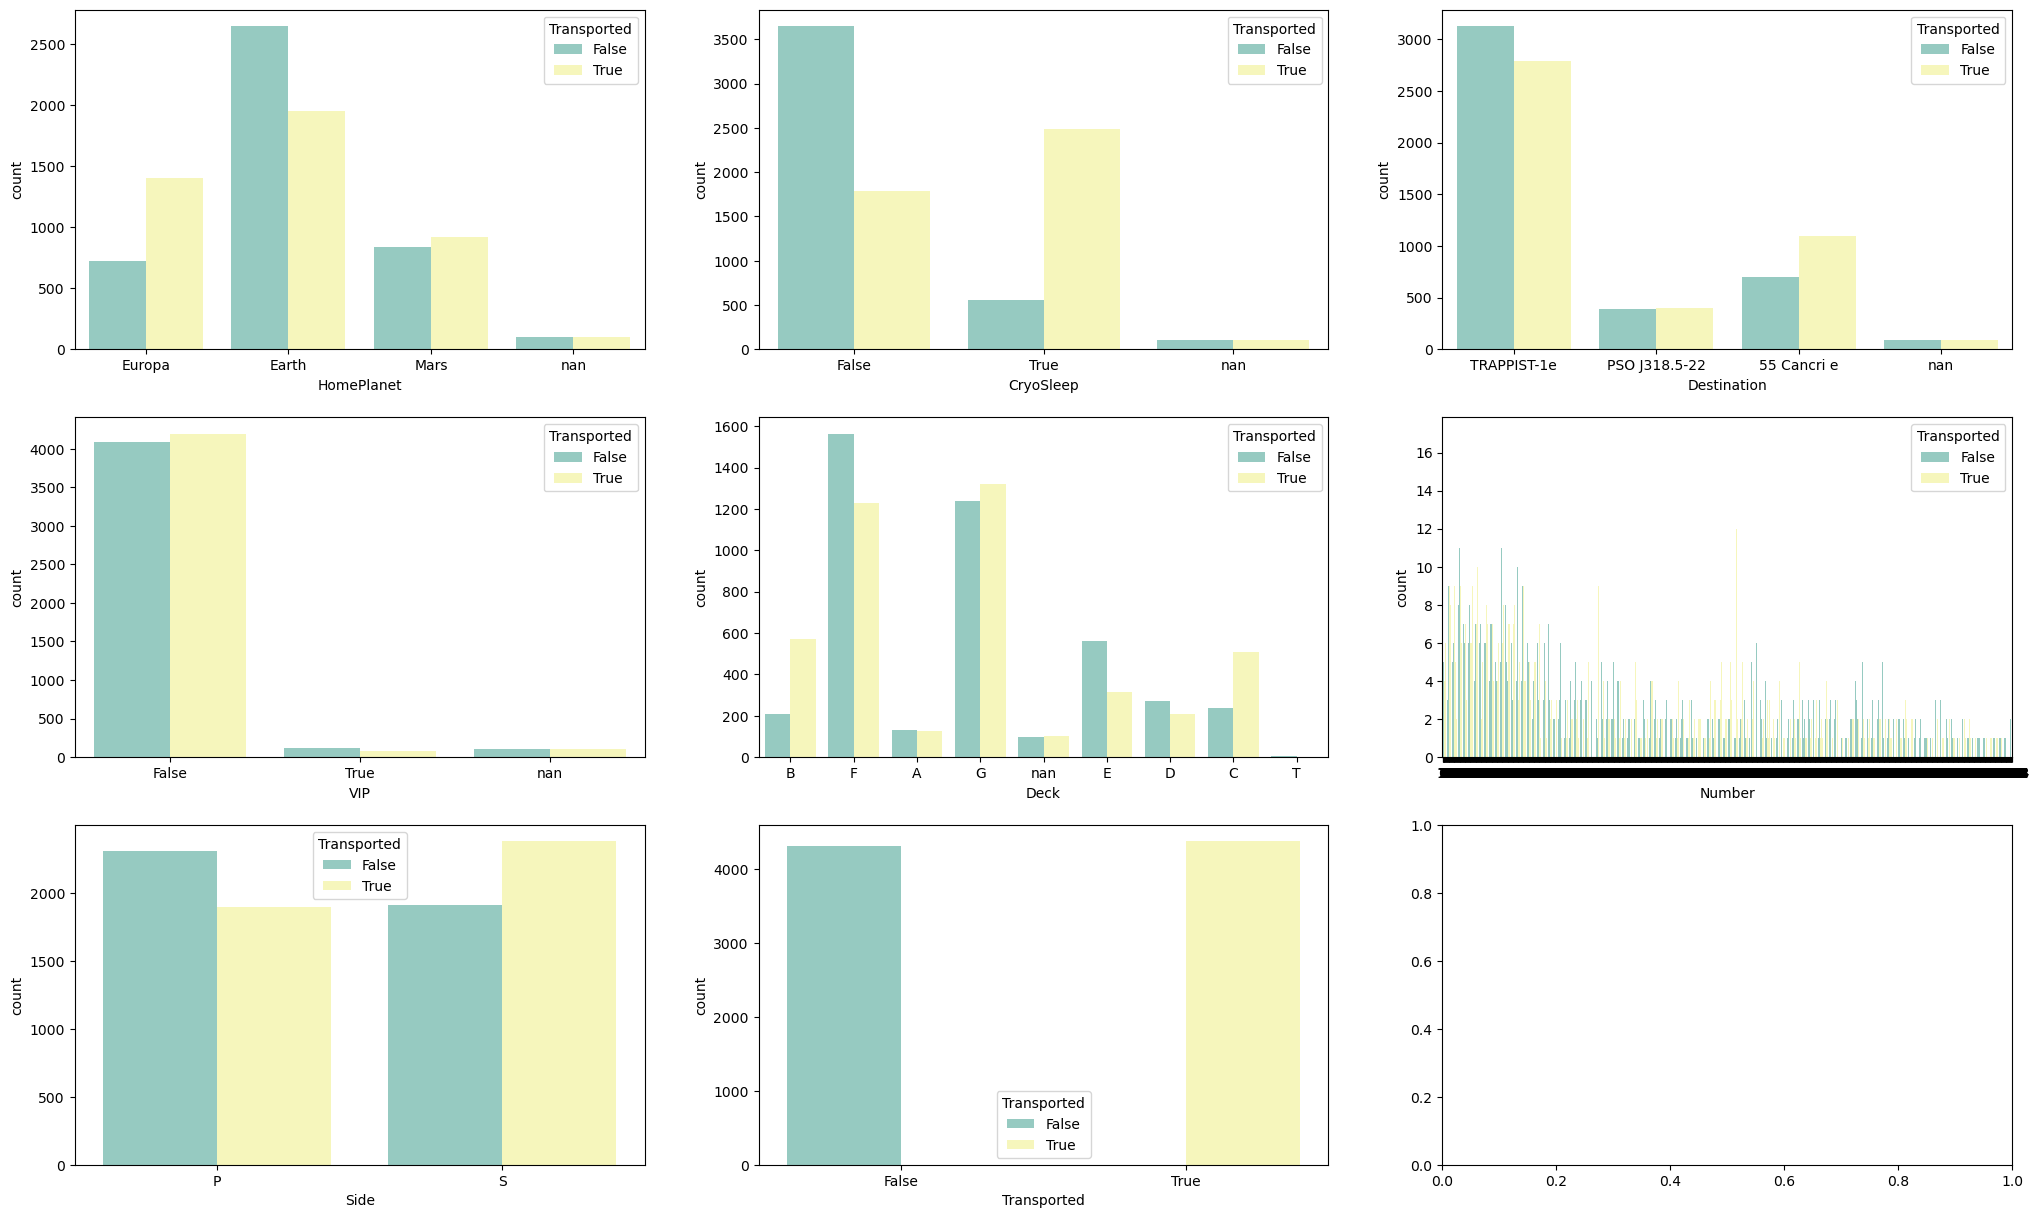

In [12]:
categories=["HomePlanet","CryoSleep","Destination","VIP","Deck","Number","Side","Transported"]
fig,ax=plt.subplots(3,3,figsize=(25,15))
ax=ax.ravel()
#sns.set(rc={'figure.figsize':(5,3)})
for i,a in enumerate(categories):
    sns.countplot(x=a,data=df,palette="Set3",hue="Transported",ax=ax[i])
    #for container in ax.containers:
       # ax.bar_label(container)
plt.show()

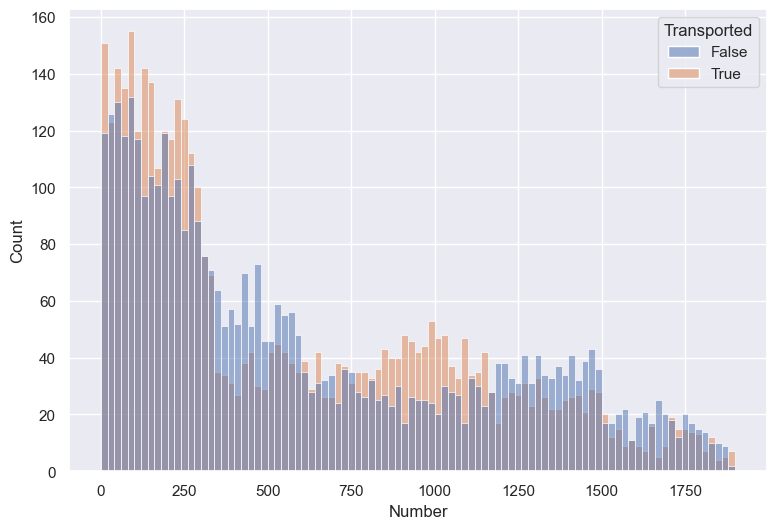

In [13]:
# we can see that the number column was a bit messed up because it has some NaN values and is not integer
sns.set(rc={'figure.figsize':(9,6)})
num_df=df.copy()
num_df=num_df[~num_df["Number"].isna()]
num_df["Number"]=num_df["Number"].astype(int)

ax=sns.histplot(x="Number",data=num_df,hue="Transported",binwidth=20)

In [14]:
# from findings we can categorise the cabin numbers to groups
df["Number"][df["Number"].isna()]=9999 # we can change this value later
df["Number"]=df["Number"].astype(int)

df["CabinCategory"]="Unknown"
df["CabinCategory"][df["Number"]<=300]="Cabin Category A"
df["CabinCategory"][df["Number"]>300]="Cabin Category B"
df["CabinCategory"][df["Number"]>600]="Cabin Category C"
df["CabinCategory"][df["Number"]>900]="Cabin Category D"
df["CabinCategory"][df["Number"]>1200]="Cabin Category E"
df["CabinCategory"][df["Number"]>1500]="Cabin Category F"
df["CabinCategory"][df["Number"]>1800]="Cabin Category G"

df["Number"][df["Number"]==9999]=np.nan#adding nan back


In [15]:
df["CabinCategory"].value_counts()

CabinCategory
Cabin Category A    3569
Cabin Category B    1484
Cabin Category D     991
Cabin Category C     976
Cabin Category E     937
Cabin Category F     459
Cabin Category G     277
Name: count, dtype: int64

In [16]:
df

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Deck,Number,Side,CabinCategory
0,0001_01,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,B,0.0,P,Cabin Category A
1,0002_01,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,F,0.0,S,Cabin Category A
2,0003_01,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,A,0.0,S,Cabin Category A
3,0003_02,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,A,0.0,S,Cabin Category A
4,0004_01,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,F,1.0,S,Cabin Category A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False,A,98.0,P,Cabin Category A
8689,9278_01,Earth,True,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False,G,1499.0,S,Cabin Category E
8690,9279_01,Earth,False,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True,G,1500.0,S,Cabin Category E
8691,9280_01,Europa,False,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False,E,608.0,S,Cabin Category C


In [17]:
# commmon techniques to replace missing values is replacing continous values with median and categorical values with mode
strings = ['HomePlanet', 'CryoSleep', 'Destination','VIP', 'Transported',"Deck","Side","CabinCategory"]
numeric = [ 'Age','RoomService','FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',"Number"]

for s in strings:
    mode=df[s].mode()[0]
    df[s]=df[s].fillna(mode)
    df[s][df[s]=="nan"] = mode

for i in numeric:
    mode=df[i].mode()[0]
    df[i]=df[i].fillna(mode)

In [18]:
df.isnull().sum()

PassengerId      0
HomePlanet       0
CryoSleep        0
Destination      0
Age              0
VIP              0
RoomService      0
FoodCourt        0
ShoppingMall     0
Spa              0
VRDeck           0
Name             0
Transported      0
Deck             0
Number           0
Side             0
CabinCategory    0
dtype: int64

In [19]:
#checking distribution of data


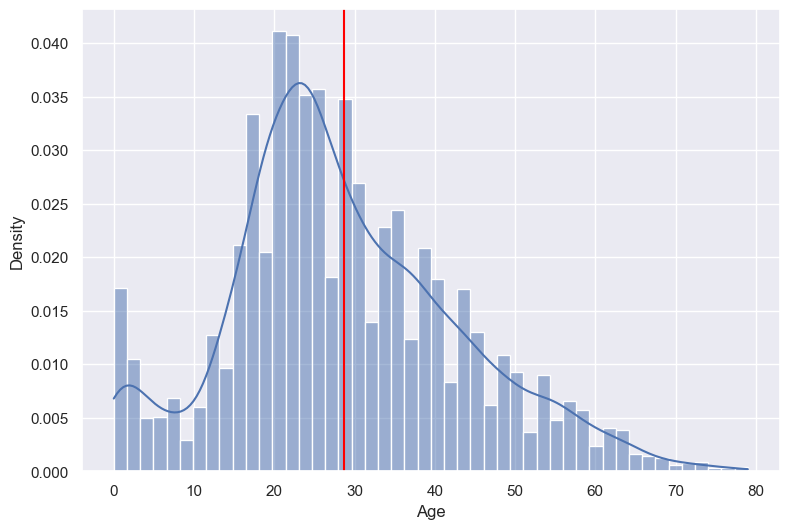

In [20]:
sns.histplot(df["Age"],kde=True,stat="density")
mean=df["Age"].mean()
plt.axvline(mean,0,1,color="red")

C:\Users\Chandru\AppData\Local\Temp\ipykernel_4540\3530961477.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df["RoomService"],color="blue")


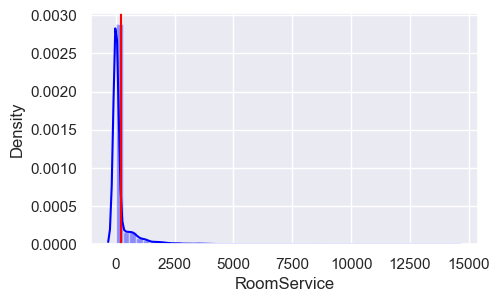

In [21]:
sns.set(rc={'figure.figsize':(5,3)})
sns.distplot(df["RoomService"],color="blue")
mean=df["RoomService"].mean()
plt.axvline(mean,0,1,color="red")
# if ur not getting good plot with histplot, try distplot

C:\Users\Chandru\AppData\Local\Temp\ipykernel_4540\1096861841.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df["FoodCourt"],color="blue")


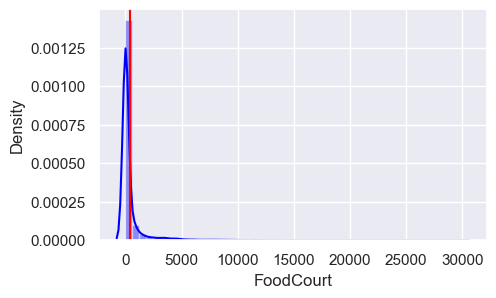

In [22]:
sns.set(rc={'figure.figsize':(5,3)})
sns.distplot(df["FoodCourt"],color="blue")
mean=df["FoodCourt"].mean()
plt.axvline(mean,0,1,color="red")

C:\Users\Chandru\AppData\Local\Temp\ipykernel_4540\687334918.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df["ShoppingMall"],color="blue")


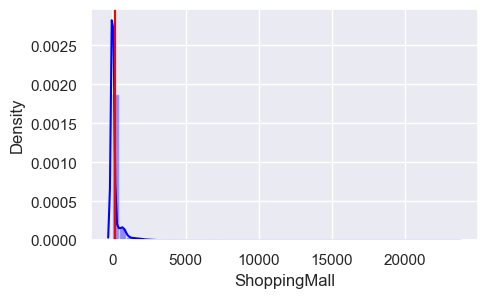

In [23]:
sns.set(rc={'figure.figsize':(5,3)})
sns.distplot(df["ShoppingMall"],color="blue")
mean=df["ShoppingMall"].mean()
plt.axvline(mean,0,1,color="red")

C:\Users\Chandru\AppData\Local\Temp\ipykernel_4540\3114306820.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df["Spa"],color="blue")


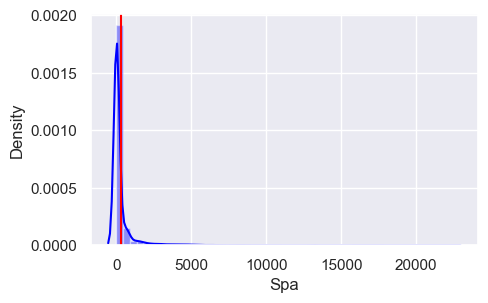

In [24]:
sns.set(rc={'figure.figsize':(5,3)})
sns.distplot(df["Spa"],color="blue")
mean=df["Spa"].mean()
plt.axvline(mean,0,1,color="red")

C:\Users\Chandru\AppData\Local\Temp\ipykernel_4540\880828228.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df["VRDeck"],color="blue")


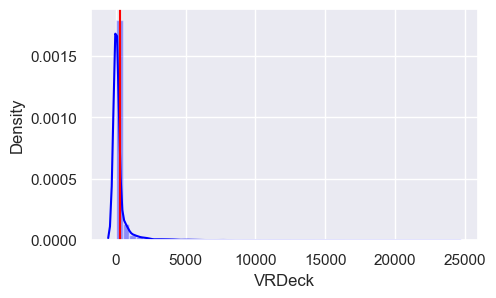

In [25]:
sns.set(rc={'figure.figsize':(5,3)})
sns.distplot(df["VRDeck"],color="blue")
mean=df["VRDeck"].mean()
plt.axvline(mean,0,1,color="red")

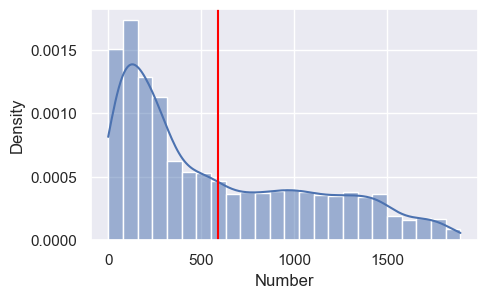

In [26]:
sns.histplot(df["Number"],kde=True,stat="density")
mean=df["Number"].mean()
plt.axvline(mean,0,1,color="red")

Age
median is: 27.0


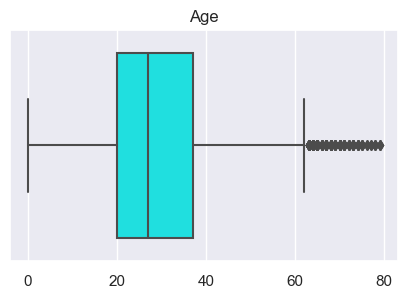

RoomService
median is: 0.0


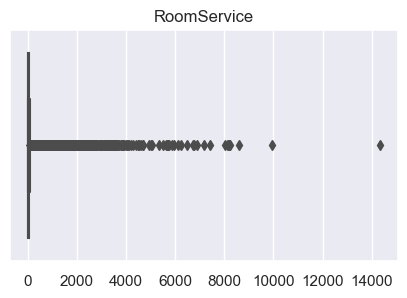

FoodCourt
median is: 0.0


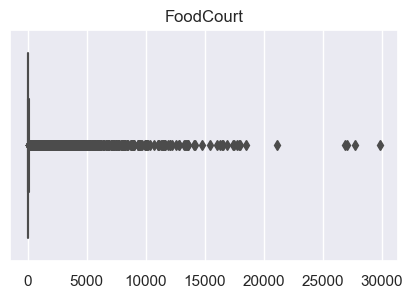

ShoppingMall
median is: 0.0


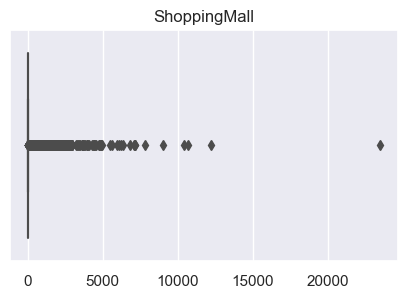

Spa
median is: 0.0


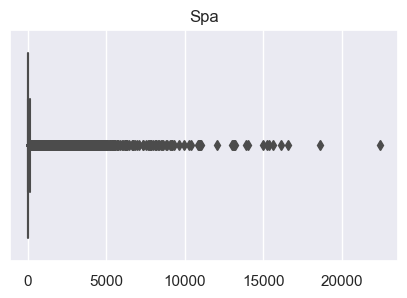

VRDeck
median is: 0.0


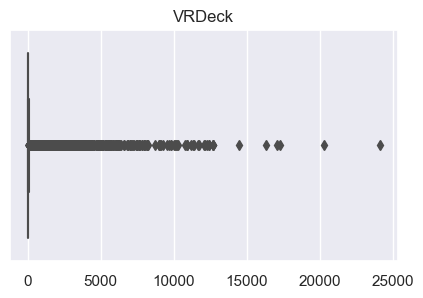

Number
median is: 407.0


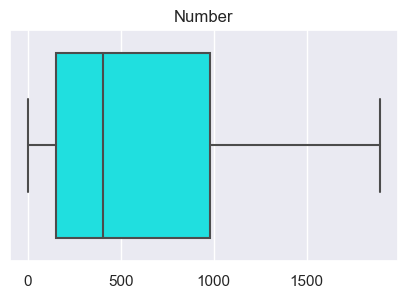

In [27]:
for i in numeric:
    print(i)
    a=df[i].values
    sns.boxplot(x=a,color="cyan")
    print("median is:",df[i].median())
    plt.title(i)
    plt.show()
# we can see that only the cabin Numbers dont seem to have any outliers
    

In [28]:
df[df["FoodCourt"]>20000]
# interesting thing to note here is that we can see for all the outliers of FoodCourt the Y(Transported) coresponded to True meaning that it has great significance on the data and does not need to be removed

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Deck,Number,Side,CabinCategory
1213,1292_01,Europa,False,55 Cancri e,31.0,True,0.0,27723.0,3.0,202.0,3146.0,Scharab Conale,True,B,55.0,S,Cabin Category A
1842,1969_01,Europa,False,55 Cancri e,27.0,False,0.0,21066.0,0.0,2448.0,2293.0,Unukath Sandul,True,C,75.0,S,Cabin Category A
2067,2215_01,Europa,False,55 Cancri e,41.0,True,0.0,29813.0,0.0,1257.0,6.0,Pulchib Quidedbolt,True,A,27.0,S,Cabin Category A
3198,3444_01,Europa,False,55 Cancri e,33.0,False,0.0,27071.0,0.0,15.0,0.0,Ainoxa Scerodbox,True,B,131.0,S,Cabin Category A
3538,3796_01,Europa,False,55 Cancri e,33.0,False,90.0,26830.0,0.0,27.0,703.0,Dhena Semageary,True,B,121.0,P,Cabin Category A


In [29]:
df[df["ShoppingMall"]>20000]

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Deck,Number,Side,CabinCategory
8415,8989_01,Europa,False,TRAPPIST-1e,17.0,False,0.0,366.0,23492.0,356.0,3.0,nan,True,B,291.0,P,Cabin Category A


In [30]:
# Use MinMaxScaler when data does not follow normal distribution otherwise use StandardScaler
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

df[['Age','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']] = scaler.fit_transform(df[['Age','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']])

In [31]:
df

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Deck,Number,Side,CabinCategory
0,0001_01,Europa,False,TRAPPIST-1e,0.493671,False,0.000000,0.000000,0.000000,0.000000,0.000000,Maham Ofracculy,False,B,0.0,P,Cabin Category A
1,0002_01,Earth,False,TRAPPIST-1e,0.303797,False,0.007608,0.000302,0.001064,0.024500,0.001823,Juanna Vines,True,F,0.0,S,Cabin Category A
2,0003_01,Europa,False,TRAPPIST-1e,0.734177,True,0.003001,0.119948,0.000000,0.299670,0.002030,Altark Susent,False,A,0.0,S,Cabin Category A
3,0003_02,Europa,False,TRAPPIST-1e,0.417722,False,0.000000,0.043035,0.015793,0.148563,0.007997,Solam Susent,False,A,0.0,S,Cabin Category A
4,0004_01,Earth,False,TRAPPIST-1e,0.202532,False,0.021149,0.002348,0.006428,0.025214,0.000083,Willy Santantines,True,F,1.0,S,Cabin Category A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,55 Cancri e,0.518987,True,0.000000,0.228726,0.000000,0.073322,0.003066,Gravior Noxnuther,False,A,98.0,P,Cabin Category A
8689,9278_01,Earth,True,PSO J318.5-22,0.227848,False,0.000000,0.000000,0.000000,0.000000,0.000000,Kurta Mondalley,False,G,1499.0,S,Cabin Category E
8690,9279_01,Earth,False,TRAPPIST-1e,0.329114,False,0.000000,0.000000,0.079687,0.000045,0.000000,Fayey Connon,True,G,1500.0,S,Cabin Category E
8691,9280_01,Europa,False,55 Cancri e,0.405063,False,0.000000,0.035186,0.000000,0.015753,0.134049,Celeon Hontichre,False,E,608.0,S,Cabin Category C


In [32]:
df = pd.get_dummies(df,columns=['HomePlanet','CryoSleep','Destination','VIP','Deck','Side','CabinCategory'],dtype=int)

In [33]:
df

,PassengerId,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Number,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,CryoSleep_False,CryoSleep_True,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,VIP_False,VIP_True,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Side_P,Side_S,CabinCategory_Cabin Category A,CabinCategory_Cabin Category B,CabinCategory_Cabin Category C,CabinCategory_Cabin Category D,CabinCategory_Cabin Category E,CabinCategory_Cabin Category F,CabinCategory_Cabin Category G
0,0001_01,0.493671,0.000000,0.000000,0.000000,0.000000,0.000000,Maham Ofracculy,False,0.0,0,1,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0
1,0002_01,0.303797,0.007608,0.000302,0.001064,0.024500,0.001823,Juanna Vines,True,0.0,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0
2,0003_01,0.734177,0.003001,0.119948,0.000000,0.299670,0.002030,Altark Susent,False,0.0,0,1,0,1,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0
3,0003_02,0.417722,0.000000,0.043035,0.015793,0.148563,0.007997,Solam Susent,False,0.0,0,1,0,1,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0
4,0004_01,0.202532,0.021149,0.002348,0.006428,0.025214,0.000083,Willy Santantines,True,1.0,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,0.518987,0.000000,0.228726,0.000000,0.073322,0.003066,Gravior Noxnuther,False,98.0,0,1,0,1,0,1,0,0,0,1,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0
8689,9278_01,0.227848,0.000000,0.000000,0.000000,0.000000,0.000000,Kurta Mondalley,False,1499.0,1,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0
8690,9279_01,0.329114,0.000000,0.000000,0.079687,0.000045,0.000000,Fayey Connon,True,1500.0,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0
8691,9280_01,0.405063,0.000000,0.035186,0.000000,0.015753,0.134049,Celeon Hontichre,False,608.0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0


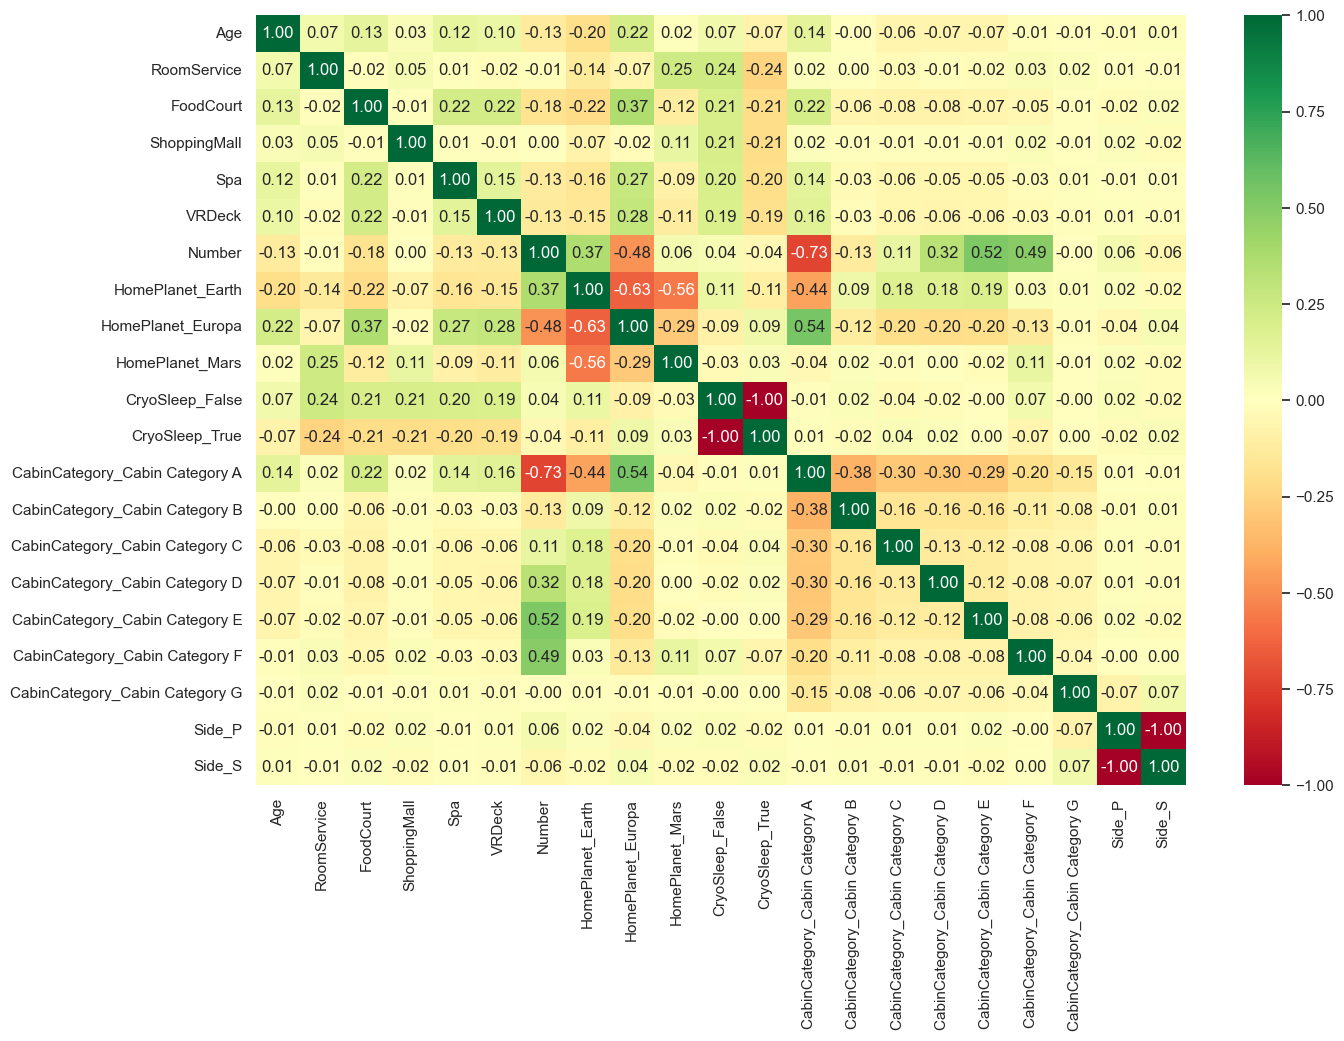

In [34]:
sns.set(rc={'figure.figsize':(15,10)})

n_variables = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa',
       'VRDeck', 'Number', 'HomePlanet_Earth',
       'HomePlanet_Europa', 'HomePlanet_Mars', 'CryoSleep_False',
       'CryoSleep_True', 'CabinCategory_Cabin Category A',
       'CabinCategory_Cabin Category B', 'CabinCategory_Cabin Category C',
       'CabinCategory_Cabin Category D', 'CabinCategory_Cabin Category E',
       'CabinCategory_Cabin Category F', 'CabinCategory_Cabin Category G',
       'Side_P', 'Side_S']

df_p1=df[n_variables]

sns.heatmap(df_p1.corr(),annot=True,fmt=".2f",cmap="RdYlGn");

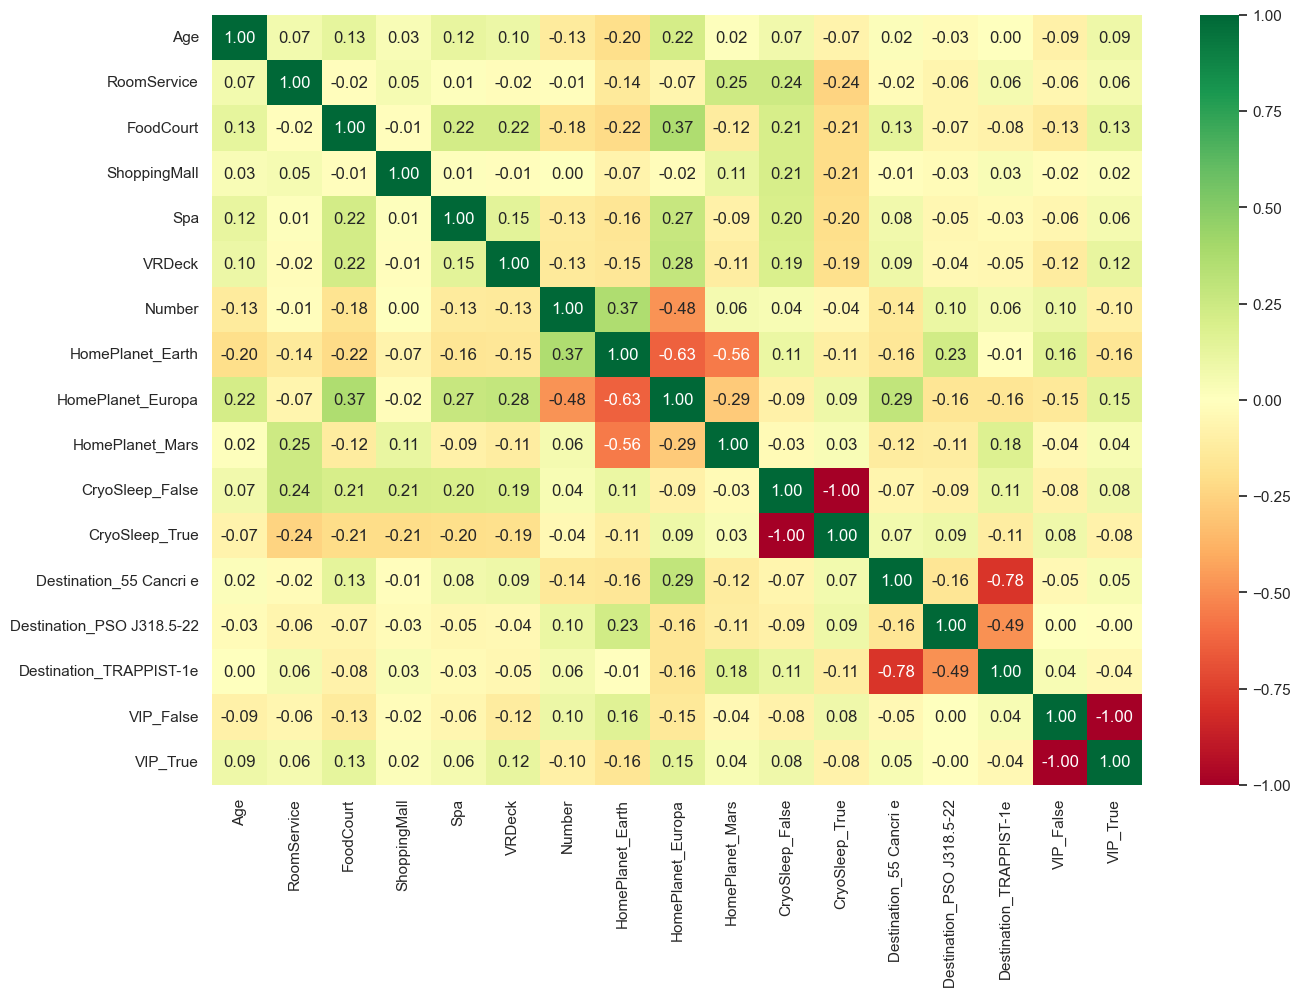

In [35]:
sns.set(rc={'figure.figsize':(15,10)})

n_variables2 = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa',
       'VRDeck', 'Number', 'HomePlanet_Earth',
       'HomePlanet_Europa', 'HomePlanet_Mars', 'CryoSleep_False',
       'CryoSleep_True', 'Destination_55 Cancri e',
       'Destination_PSO J318.5-22', 'Destination_TRAPPIST-1e', 'VIP_False',
       'VIP_True']

df_p2=df[n_variables2]

sns.heatmap(df_p2.corr(),annot=True,fmt=".2f",cmap="RdYlGn");

In [36]:
from sklearn.tree import DecisionTreeClassifier

# deleting for rerun
try:
    del final_fi
except:
    print("")
    
X=df.drop(["Transported","PassengerId","Name"],axis=1).values
X_columns=df.drop(["Transported","PassengerId","Name"],axis=1)
y=df["Transported"]


dt = DecisionTreeClassifier(random_state=42,criterion="entropy",max_depth=10)
dt.fit(X,y)


for i,column in enumerate(X_columns):
    print(f"The feature importance of {column} is: {dt.feature_importances_[i]}")
    
    fi = pd.DataFrame({'Variable': [column], 'Feature Importance Score': [dt.feature_importances_[i]]})
    
    try:
        final_fi = pd.concat([final_fi,fi], ignore_index = True)
    except:
        final_fi = fi
        
        
# Ordering the data

final_fi = final_fi.sort_values('Feature Importance Score', ascending = False).reset_index()            
final_fi


The feature importance of Age is: 0.04828315767813119
The feature importance of RoomService is: 0.057215245763596434
The feature importance of FoodCourt is: 0.07244074575828613
The feature importance of ShoppingMall is: 0.019610922297153
The feature importance of Spa is: 0.10033873082711815
The feature importance of VRDeck is: 0.10447590860403026
The feature importance of Number is: 0.06871923629705427
The feature importance of HomePlanet_Earth is: 0.08161825328554873
The feature importance of HomePlanet_Europa is: 0.014508244994123065
The feature importance of HomePlanet_Mars is: 0.0015233736901784278
The feature importance of CryoSleep_False is: 0.0
The feature importance of CryoSleep_True is: 0.30325436315402604
The feature importance of Destination_55 Cancri e is: 0.003519950611722368
The feature importance of Destination_PSO J318.5-22 is: 0.004976777064957031
The feature importance of Destination_TRAPPIST-1e is: 0.005102856024703422
The feature importance of VIP_False is: 0.0
The

,index,Variable,Feature Importance Score
0,11,CryoSleep_True,0.303254
1,5,VRDeck,0.104476
2,4,Spa,0.100339
3,7,HomePlanet_Earth,0.081618
4,2,FoodCourt,0.072441
5,6,Number,0.068719
6,1,RoomService,0.057215
7,0,Age,0.048283
8,21,Deck_E,0.038194
9,25,Side_P,0.019980


In [37]:
final_fi["Feature Importance Score"].sum()

1.0

In [38]:
model = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
model.fit(X,y)
y_pred=model.predict(X)
print("Score",model.score(X,y))

pred_proba_t = model.predict_proba(X)
log_loss = log_loss(y, pred_proba_t)
log_loss


print('Log Loss', log_loss)

Score 0.8057057402507765
Log Loss 0.40680471218848185


In [39]:
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt
from sklearn.model_selection import RandomizedSearchCV

model2=GradientBoostingClassifier()
parameters={'n_estimators':sp_randFloat(),'learning_rate':sp_randFloat(),'n_estimators':sp_randInt(100,1000),
            'max_depth':sp_randInt(1,10)}

randm= RandomizedSearchCV(estimator=model2,param_distributions=parameters,cv=2,n_iter=10,n_jobs=-1)
randm.fit(X,y)

print("Score",randm.best_score_)

Score 0.7863800150560589


In [40]:
evaluation_data

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,9266_02,Earth,True,G/1496/S,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,Jeron Peter
4273,9269_01,Earth,False,NaN,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0,Matty Scheron
4274,9271_01,Mars,True,D/296/P,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,Jayrin Pore
4275,9273_01,Europa,False,D/297/P,NaN,NaN,False,0.0,2680.0,0.0,0.0,523.0,Kitakan Conale


In [41]:
df_test=evaluation_data.copy()

In [42]:
strings = ['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination','VIP','Name']
numeric = [ 'Age','RoomService','FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

for i in strings:
    df_test[i]=df_test[i].astype("str")

for i in numeric:
    df_test[i]=df_test[i].astype("float")

In [43]:
df_test[["Deck","Number","Side"]]=df_test["Cabin"].str.split("/",expand=True)
del df_test["Cabin"]

In [44]:
# from findings we can categorise the cabin numbers to groups
df_test["Number"][df_test["Number"].isna()]=9999 # we can change this value later
df_test["Number"]=df_test["Number"].astype(int)

df_test["CabinCategory"]="Unknown"
df_test["CabinCategory"][df_test["Number"]<=300]="Cabin Category A"
df_test["CabinCategory"][df_test["Number"]>300]="Cabin Category B"
df_test["CabinCategory"][df_test["Number"]>600]="Cabin Category C"
df_test["CabinCategory"][df_test["Number"]>900]="Cabin Category D"
df_test["CabinCategory"][df_test["Number"]>1200]="Cabin Category E"
df_test["CabinCategory"][df_test["Number"]>1500]="Cabin Category F"
df_test["CabinCategory"][df_test["Number"]>1800]="Cabin Category G"

df_test["Number"][df_test["Number"]==9999]=np.NaN

In [45]:
df_test

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Deck,Number,Side,CabinCategory
0,0013_01,Earth,True,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning,G,3.0,S,Cabin Category A
1,0018_01,Earth,False,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers,F,4.0,S,Cabin Category A
2,0019_01,Europa,True,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus,C,0.0,S,Cabin Category A
3,0021_01,Europa,False,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter,C,1.0,S,Cabin Category A
4,0023_01,Earth,False,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez,F,5.0,S,Cabin Category A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,9266_02,Earth,True,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,Jeron Peter,G,1496.0,S,Cabin Category E
4273,9269_01,Earth,False,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0,Matty Scheron,nan,NaN,None,Cabin Category G
4274,9271_01,Mars,True,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,Jayrin Pore,D,296.0,P,Cabin Category A
4275,9273_01,Europa,False,nan,NaN,False,0.0,2680.0,0.0,0.0,523.0,Kitakan Conale,D,297.0,P,Cabin Category A


In [46]:
strings = ['HomePlanet', 'CryoSleep', 'Destination','VIP',"Deck","Side","CabinCategory"]
numeric = [ 'Age','RoomService','FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',"Number"]

for s in strings:
    mode=df_test[s].mode()[0]
    df_test[s]=df_test[s].fillna(mode)
    df_test[s][df_test[s]=="nan"] = mode

for i in numeric:
    mode=df_test[i].mode()[0]
    df_test[i]=df_test[i].fillna(mode)

In [47]:
df_test

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Deck,Number,Side,CabinCategory
0,0013_01,Earth,True,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning,G,3.0,S,Cabin Category A
1,0018_01,Earth,False,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers,F,4.0,S,Cabin Category A
2,0019_01,Europa,True,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus,C,0.0,S,Cabin Category A
3,0021_01,Europa,False,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter,C,1.0,S,Cabin Category A
4,0023_01,Earth,False,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez,F,5.0,S,Cabin Category A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,9266_02,Earth,True,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,Jeron Peter,G,1496.0,S,Cabin Category E
4273,9269_01,Earth,False,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0,Matty Scheron,F,4.0,S,Cabin Category G
4274,9271_01,Mars,True,55 Cancri e,18.0,False,0.0,0.0,0.0,0.0,0.0,Jayrin Pore,D,296.0,P,Cabin Category A
4275,9273_01,Europa,False,TRAPPIST-1e,18.0,False,0.0,2680.0,0.0,0.0,523.0,Kitakan Conale,D,297.0,P,Cabin Category A


In [48]:
df_test["Side"].mode()[0]

'S'

In [49]:
df_test[['Age','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']] = scaler.fit_transform(df_test[['Age','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']])
df_test = pd.get_dummies(df_test,columns=['HomePlanet','CryoSleep','Destination','VIP','Deck','Side','CabinCategory'],dtype=int)

In [50]:
df_test

,PassengerId,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Number,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,CryoSleep_False,CryoSleep_True,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,VIP_False,VIP_True,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Side_P,Side_S,CabinCategory_Cabin Category A,CabinCategory_Cabin Category B,CabinCategory_Cabin Category C,CabinCategory_Cabin Category D,CabinCategory_Cabin Category E,CabinCategory_Cabin Category F,CabinCategory_Cabin Category G
0,0013_01,0.341772,0.000000,0.000000,0.00000,0.000000,0.000000,Nelly Carsoning,3.0,1,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0
1,0018_01,0.240506,0.000000,0.000356,0.00000,0.142260,0.000000,Lerome Peckers,4.0,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0
2,0019_01,0.392405,0.000000,0.000000,0.00000,0.000000,0.000000,Sabih Unhearfus,0.0,0,1,0,0,1,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0
3,0021_01,0.481013,0.000000,0.263206,0.00000,0.009121,0.026266,Meratz Caltilter,1.0,0,1,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0
4,0023_01,0.253165,0.000865,0.000000,0.07658,0.000000,0.000000,Brence Harperez,5.0,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,9266_02,0.430380,0.000000,0.000000,0.00000,0.000000,0.000000,Jeron Peter,1496.0,1,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0
4273,9269_01,0.531646,0.000000,0.033514,0.00205,0.000504,0.006466,Matty Scheron,4.0,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1
4274,9271_01,0.227848,0.000000,0.000000,0.00000,0.000000,0.000000,Jayrin Pore,296.0,0,0,1,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0
4275,9273_01,0.227848,0.000000,0.106042,0.00000,0.000000,0.023482,Kitakan Conale,297.0,0,1,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0


In [51]:
X_test=df_test.drop(["PassengerId","Name"],axis=1).values
y_pred=model.predict(X_test)

In [52]:
evaluation_data['Transported'] = y_pred
output = evaluation_data[['PassengerId','Transported']]
output.to_csv('submission1.csv', index=False)

In [53]:
output

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
...,...,...
4272,9266_02,True
4273,9269_01,False
4274,9271_01,True
4275,9273_01,True


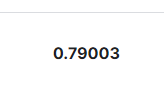

In [60]:
ynew = df["Transported"].replace({'False': 0, 'True': 1})

In [56]:
import xgboost
classifier = xgboost.XGBClassifier(random_state=42)
params = {
    'learning_rate': [0.05, 0.1, 0.2],  # Learning rate: Typical range [0.01, 0.3]
    'max_depth': [3, 6, 9],  # Maximum depth of a tree: Typical range [3, 10]
    'n_estimators': [50, 100, 200],  # Number of boosting rounds (iterations): Number of trees to build
    'subsample': [0.6, 0.8, 1.0],  # Subsample ratio of the training instance: Typical range [0.5, 1]
    'colsample_bytree': [0.6, 0.8, 1.0],  # Subsample ratio of columns when constructing each tree: Typical range [0.5, 1]
    'gamma': [0, 0.1, 0.2],  # Minimum loss reduction required to make a further partition on a leaf node of the tree: Regularization parametera
    'min_child_weight': [1, 3, 5]  # Minimum sum of instance weight (hessian) needed in a child: Regularization parameter
}

skf = StratifiedKFold(n_splits=5,shuffle=True,random_state=42)

model3 = RandomizedSearchCV(classifier,param_distributions=params,n_iter=50,scoring='roc_auc',cv=skf.split(X,ynew),n_jobs=-1,random_state=42)
model3.fit(X,ynew)
finalmodel3=model3.best_estimator_
finalmodel3.fit(X,ynew)
print("Score",finalmodel3.score(X,ynew))

Score 0.8603474059588174


In [58]:
X_test=df_test.drop(["PassengerId","Name"],axis=1).values
y_pred=model3.predict(X_test)
evaluation_data['Transported'] = y_pred
evaluation_data['Transported'] = evaluation_data["Transported"].replace({0: 'False', 1: 'True'})
output = evaluation_data[['PassengerId','Transported']]
output.to_csv('submission2.csv', index=False)

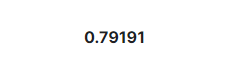

In [59]:
final_fi['Variable'].values[0:14]

array(['CryoSleep_True', 'VRDeck', 'Spa', 'HomePlanet_Earth', 'FoodCourt',
       'Number', 'RoomService', 'Age', 'Deck_E', 'Side_P', 'ShoppingMall',
       'Side_S', 'HomePlanet_Europa', 'CabinCategory_Cabin Category D'],
      dtype=object)

In [64]:
X=df[['CryoSleep_True', 'VRDeck', 'Spa', 'HomePlanet_Earth', 'FoodCourt',
       'Number', 'RoomService', 'Age', 'Deck_E', 'Side_P', 'ShoppingMall',
       'Side_S', 'HomePlanet_Europa', 'CabinCategory_Cabin Category D']].values


classifier=xgboost.XGBClassifier(learning_rate=0.02, n_estimators=600, silent=True, nthread=1)

params={
    "learning_rate":[0.05,0.10,0.15,0.20,0.25,0.30],
    "max_depth":[2,3,4,5,6,8,10,12,15],
    "min_child_weight":[1,3,5,7,10],
    "gamma":[0.0,0.1,0.2,0.3,0.4,0.5, 1, 1.5, 2, 5],
    "colsample_bytree":[0.3,0.4,0.5,0.7, 0.8, 1.0],
    'subsample': [0.6, 0.8, 1.0]}

skf = StratifiedKFold(n_splits=5, shuffle = True, random_state = 42)

model4 = RandomizedSearchCV(classifier,param_distributions=params,n_iter=50,scoring='neg_log_loss',cv=skf.split(X,ynew),n_jobs=-1,random_state=42)
model4.fit(X,ynew)
finalmodel4=model4.best_estimator_
finalmodel4.fit(X,ynew)
print("Score",finalmodel4.score(X,ynew))

C:\Users\Chandru\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [15:56:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


Score 0.8788680547567008


In [66]:
X_test=df_test[['CryoSleep_True', 'VRDeck', 'Spa', 'HomePlanet_Earth', 'FoodCourt',
       'Number', 'RoomService', 'Age', 'Deck_E', 'Side_P', 'ShoppingMall',
       'Side_S', 'HomePlanet_Europa', 'CabinCategory_Cabin Category D']].values
y_pred=model4.predict(X_test)
evaluation_data['Transported'] = y_pred
evaluation_data['Transported'] = evaluation_data["Transported"].replace({0: 'False', 1: 'True'})
output = evaluation_data[['PassengerId','Transported']]
output.to_csv('submission3.csv', index=False)

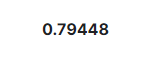